# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='https://raw.githubusercontent.com/learn-co-students/dsc-mod-4-project-seattle-ds-102819/master/images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
"""
you will be forecasting real estate prices of various zip codes 

What are the top 5 best zip codes for us to invest in?

Should your recommendation be focused on profit margins only? 
What about risk? 
What sort of time horizon are you predicting against? 
Your recommendation will need to detail your rationale and answer any sort of lingering questions like these 
    in order to demonstrate how you define "best".

Evaluation
In addition to deciding which quantitative metric(s) you want to target (e.g. minimizing mean squared error), 
    you need to start with a definition of "best investment". 
    Consider additional metrics like risk vs. profitability, or ROI yield.


"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings('ignore')
import itertools
import statsmodels.api as sm

#from matplotlib.pylab import rcParams

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#pd.set_option('display.max_columns', None)  
zillow = pd.read_csv('zillow_data.csv')
zillow.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [3]:
zillow.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
zillow.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID','Zipcode', 'City', 'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='Month', value_name='MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format='%Y-%m')
    #melted = melted.set_index('Month')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [5]:
all_zipcodes = melt_data(zillow)

In [6]:
all_zipcodes.columns

Index(['RegionID', 'Zipcode', 'City', 'State', 'Metro', 'CountyName',
       'SizeRank', 'Month', 'MeanValue'],
      dtype='object')

In [7]:
all_zipcodes.head(10)

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
0,84654,60657,Chicago,IL,Chicago,Cook,1,1996-04-01,334200.0
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,1996-04-01,235700.0
2,91982,77494,Katy,TX,Houston,Harris,3,1996-04-01,210400.0
3,84616,60614,Chicago,IL,Chicago,Cook,4,1996-04-01,498100.0
4,93144,79936,El Paso,TX,El Paso,El Paso,5,1996-04-01,77300.0
5,91733,77084,Houston,TX,Houston,Harris,6,1996-04-01,95000.0
6,61807,10467,New York,NY,New York,Bronx,7,1996-04-01,152900.0
7,84640,60640,Chicago,IL,Chicago,Cook,8,1996-04-01,216500.0
8,91940,77449,Katy,TX,Houston,Harris,9,1996-04-01,95400.0
9,97564,94109,San Francisco,CA,San Francisco,San Francisco,10,1996-04-01,766000.0


In [8]:
kings_zips = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY')]
kings_zips

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
10,62037,11226,New York,NY,New York,Kings,11,1996-04-01,162000.0
13,62045,11235,New York,NY,New York,Kings,14,1996-04-01,190500.0
47,62040,11230,New York,NY,New York,Kings,48,1996-04-01,230100.0
49,62020,11209,New York,NY,New York,Kings,50,1996-04-01,255700.0
53,62023,11212,New York,NY,New York,Kings,54,1996-04-01,125000.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [9]:
"""
test_dict = {}

for zipcode in kings['Zipcode'].unique(): 
    all_zips = kings[kings['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    brooklyn_zips[zipcode] = all_zips
"""
test_dict = {}

for zipcode in kings_zips['Zipcode'].unique(): 
    all_zips = kings_zips[kings_zips['Zipcode'] == zipcode]
    all_zips = all_zips.set_index('Month')['MeanValue']
    all_zips = all_zips.asfreq('MS')
    all_zips.name = zipcode
    test_dict[zipcode] = all_zips

In [10]:
test_dict

{11226: Month
 1996-04-01    162000.0
 1996-05-01    162300.0
 1996-06-01    162600.0
 1996-07-01    163000.0
 1996-08-01    163400.0
                 ...   
 2017-12-01    887800.0
 2018-01-01    890500.0
 2018-02-01    901700.0
 2018-03-01    930700.0
 2018-04-01    963200.0
 Freq: MS, Name: 11226, Length: 265, dtype: float64,
 11235: Month
 1996-04-01    190500.0
 1996-05-01    191000.0
 1996-06-01    191500.0
 1996-07-01    192000.0
 1996-08-01    192500.0
                 ...   
 2017-12-01    799700.0
 2018-01-01    806600.0
 2018-02-01    810600.0
 2018-03-01    813400.0
 2018-04-01    816200.0
 Freq: MS, Name: 11235, Length: 265, dtype: float64,
 11230: Month
 1996-04-01     230100.0
 1996-05-01     230800.0
 1996-06-01     231500.0
 1996-07-01     232100.0
 1996-08-01     232800.0
                 ...    
 2017-12-01    1102400.0
 2018-01-01    1120200.0
 2018-02-01    1141600.0
 2018-03-01    1170000.0
 2018-04-01    1195400.0
 Freq: MS, Name: 11230, Length: 265, dtype: float

In [11]:
zip_df = pd.concat(test_dict, axis=1)

In [12]:
len(zip_df)

265

In [13]:
zip_df.head()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
1996-04-01,162000.0,190500.0,230100.0,255700.0,125000.0,191000.0,133700.0,183900.0,172300.0,225700.0,...,149000.0,188500.0,146100.0,187300.0,158000.0,149200.0,219300.0,NaN,NaN,NaN
1996-05-01,162300.0,191000.0,230800.0,256600.0,125000.0,191200.0,133700.0,184200.0,172100.0,227500.0,...,149200.0,188700.0,146600.0,187300.0,157300.0,148400.0,219600.0,NaN,NaN,NaN
1996-06-01,162600.0,191500.0,231500.0,257300.0,125000.0,191500.0,133700.0,184500.0,171900.0,229400.0,...,149400.0,188800.0,147200.0,187200.0,156700.0,147500.0,219900.0,NaN,NaN,NaN
1996-07-01,163000.0,192000.0,232100.0,258100.0,125000.0,191900.0,133700.0,184800.0,171600.0,231600.0,...,149600.0,189000.0,147700.0,187100.0,156100.0,146600.0,220200.0,NaN,NaN,NaN
1996-08-01,163400.0,192500.0,232800.0,258900.0,125100.0,192100.0,133900.0,185000.0,171400.0,234100.0,...,149700.0,189400.0,148400.0,187000.0,155600.0,146000.0,220600.0,NaN,NaN,NaN


In [14]:
zip_df.tail()

,11226,11235,11230,11209,11212,11214,11221,11229,11234,11215,...,11203,11220,11216,11210,11224,11222,11228,11238,11205,11217
Month,,,,,,,,,,,,,,,,,,,,,
2017-12-01,887800.0,799700.0,1102400.0,1018900.0,414900.0,826300.0,998100.0,741000.0,575000.0,2287100.0,...,474500.0,903000.0,1545700.0,802900.0,498700.0,1651200.0,902200.0,2768900.0,2251000.0,3404100.0
2018-01-01,890500.0,806600.0,1120200.0,1023500.0,422300.0,827600.0,1000900.0,748100.0,579400.0,2288900.0,...,475300.0,906500.0,1540200.0,809100.0,502000.0,1661800.0,909000.0,2810700.0,2251600.0,3413800.0
2018-02-01,901700.0,810600.0,1141600.0,1029200.0,426300.0,830500.0,1015400.0,755800.0,583200.0,2265300.0,...,474800.0,910700.0,1553600.0,814500.0,505600.0,1672800.0,912800.0,2848100.0,2245300.0,3482900.0
2018-03-01,930700.0,813400.0,1170000.0,1023000.0,427100.0,837300.0,1037300.0,766200.0,589400.0,2244900.0,...,481000.0,915600.0,1578400.0,816900.0,511600.0,1694000.0,913900.0,2869600.0,2243700.0,3588100.0
2018-04-01,963200.0,816200.0,1195400.0,1015800.0,428400.0,844100.0,1048700.0,775500.0,593300.0,2243900.0,...,489900.0,917900.0,1598700.0,819600.0,517900.0,1721100.0,915300.0,2885300.0,2248400.0,3656000.0


In [15]:
zip_df.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Month', length=265, freq='MS')

In [16]:
zip_df.isna().sum()

11226     0
11235     0
11230     0
11209     0
11212     0
11214     0
11221     0
11229     0
11234     0
11215     0
11211     0
11233     0
11236     0
11218     0
11223     0
11208     0
11204     0
11219     0
11203     0
11220     0
11216     0
11210     0
11224     0
11222     0
11228     0
11238    93
11205    93
11217    93
dtype: int64

In [17]:
zip_df.bfill(inplace=True)

In [18]:
zip_df[11205].value_counts(dropna=False)

833100.0     94
1290900.0     2
2351000.0     2
1355000.0     2
2248400.0     2
             ..
1411700.0     1
1036600.0     1
1659500.0     1
1345800.0     1
1258500.0     1
Name: 11205, Length: 168, dtype: int64

In [19]:
zip_df.keys()

Int64Index([11226, 11235, 11230, 11209, 11212, 11214, 11221, 11229, 11234,
            11215, 11211, 11233, 11236, 11218, 11223, 11208, 11204, 11219,
            11203, 11220, 11216, 11210, 11224, 11222, 11228, 11238, 11205,
            11217],
           dtype='int64')

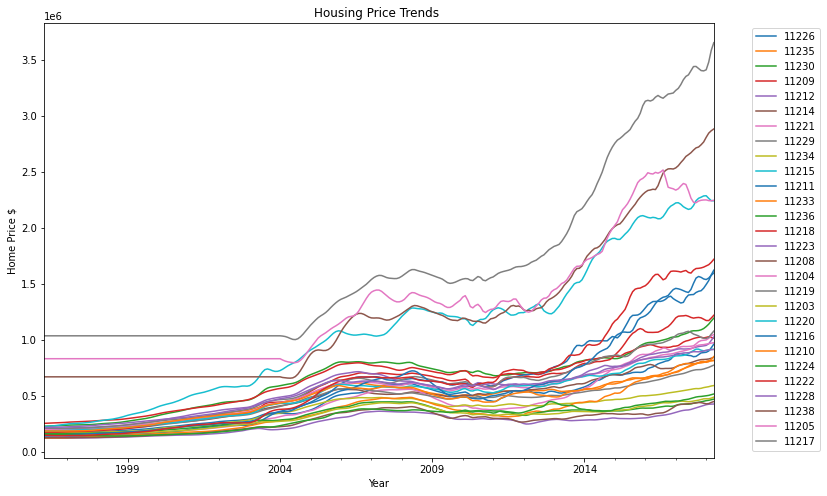

In [98]:
zip_df.plot(figsize=(12,8))
plt.title("Housing Price Trends ")
#plt.set(title=f'Baltimore Crime Rates - {zip_df.index.freq}')
plt.xlabel('Year')
plt.ylabel('Home Price $')
plt.legend(bbox_to_anchor=(1.05,1),loc='upper left')

In [21]:
year = '2014'
train_brk = zip_df.loc[:year]
test_brk = zip_df.loc[year:]

In [22]:
print(len(zip_df))
print(train_brk.shape)
print(test_brk.shape)

265
(225, 28)
(52, 28)


In [23]:
zip_df[11220]

Month
1996-04-01    188500.0
1996-05-01    188700.0
1996-06-01    188800.0
1996-07-01    189000.0
1996-08-01    189400.0
                ...   
2017-12-01    903000.0
2018-01-01    906500.0
2018-02-01    910700.0
2018-03-01    915600.0
2018-04-01    917900.0
Freq: MS, Name: 11220, Length: 265, dtype: float64

In [24]:
train_brk[11220]

Month
1996-04-01    188500.0
1996-05-01    188700.0
1996-06-01    188800.0
1996-07-01    189000.0
1996-08-01    189400.0
                ...   
2014-08-01    680000.0
2014-09-01    684100.0
2014-10-01    688300.0
2014-11-01    695400.0
2014-12-01    699600.0
Freq: MS, Name: 11220, Length: 225, dtype: float64

In [25]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [26]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm
from pmdarima import auto_arima

In [27]:
#stepwise_fit = auto_arima(train_brk[11220],start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 1, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=1, D=1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    display(autoarima_model.summary())
    
    #autoarima_model.plot_diagnostics(figsize=(12,10))
    
    return autoarima_model

    #autoarima_model.summary()

In [29]:
stepwise_fit = arima_model(train_brk[11220])

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4327.373, BIC=4347.513, Fit time=2.159 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=4341.425, BIC=4348.139, Fit time=0.025 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=4417.531, BIC=4430.958, Fit time=0.405 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=4315.571, BIC=4328.998, Fit time=0.445 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=4276.972, BIC=4293.755, Fit time=1.812 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=4321.820, BIC=4335.246, Fit time=0.293 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=4282.564, BIC=4302.703, Fit time=4.006 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=4312.603, BIC=4322.673, Fit time=0.256 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=4282.622, BIC=4306.118, Fit time=4.744 seconds
Fit ARIMA: order=(0, 1, 0) s

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  225
Model:             SARIMAX(0, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -2127.646
Date:                            Thu, 05 Nov 2020   AIC                           4269.292
Time:                                    11:35:38   BIC                           4292.788
Sample:                                         0   HQIC                          4278.789
                                            - 225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     85.9357     60.462      1.421      0.155     -32.567     204.439
ma.L1          0.1707      0.011     15.897      0.000       0.150       0.192
ma.L2          0.1064      0.018      5.823      0.000       0.071       0.142
ma.L3          0.0600      0.039      1.556      0.120      -0.016       0.136
ar.S.L12       0.6425      0.031     20.775      0.000       0.582       0.703
ma.S.L12      -1.0000      0.087    -11.547      0.000      -1.170      -0.830
sigma2       2.73e+07   3.15e-09   8.68e+15      0.000    2.73e+07    2.73e+07
===================================================================================
Ljung-Box (Q):                      297.08   Jarque-Bera (JB):                28.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+36. Standard errors may be unstable.
"""

In [30]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  225
Model:             SARIMAX(0, 1, 3)x(1, 1, 1, 12)   Log Likelihood               -2127.646
Date:                            Thu, 05 Nov 2020   AIC                           4269.292
Time:                                    11:35:38   BIC                           4292.788
Sample:                                         0   HQIC                          4278.789
                                            - 225                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     85.9357     60.462      1.421      0.155     -32.567     204.439
ma.L1          0.1707      0.011     15.897      0.000       0.150       0.192
ma.L2          0.1064      0.018      5.823      0.000       0.071       0.142
ma.L3          0.0600      0.039      1.556      0.120      -0.016       0.136
ar.S.L12       0.6425      0.031     20.775      0.000       0.582       0.703
ma.S.L12      -1.0000      0.087    -11.547      0.000      -1.170      -0.830
sigma2       2.73e+07   3.15e-09   8.68e+15      0.000    2.73e+07    2.73e+07
===================================================================================
Ljung-Box (Q):                      297.08   Jarque-Bera (JB):                28.17
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.50   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.68e+36. Standard errors may be unstable.
"""

In [31]:
#length of test data
future_forecast = stepwise_fit.predict(n_periods=52)
print(future_forecast)

[704378.10870094 710162.41865624 713611.82304689 717350.83104583
 717270.41566033 716943.8461212  718138.62697148 721715.50368646
 726192.01344076 730777.07822044 737339.69891881 741911.65929357
 746605.97631541 751763.5809553  755034.51350744 762032.8195601
 763592.94735586 765005.76850213 767503.90083509 771665.86437858
 776470.22116105 781388.62965877 787691.91447223 792588.79885304
 797315.214601   802156.0904934  805398.28881666 814576.66238364
 817276.79140185 819893.12428649 823314.60878307 827938.43222341
 833039.36974292 838257.89065623 844480.4852774  849672.07232412
 854505.04754953 859228.35775802 862538.02977308 873203.05437468
 876721.58137085 880197.1183789  884297.80165344 889304.31044725
 894681.73979716 900179.02167988 906435.70776366 911902.5799612
 916889.95644592 921623.66524263 925062.6255065  936768.77407801]


<AxesSubplot:xlabel='Month'>

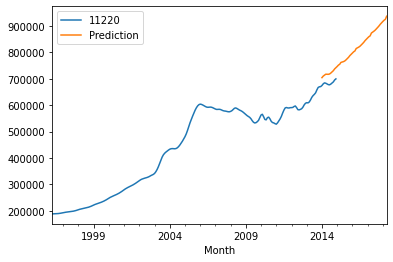

In [32]:
future_forecast = pd.DataFrame(future_forecast,index = test_brk.index,columns=['Prediction'])
pd.concat([train_brk[11220],future_forecast],axis=1).plot()

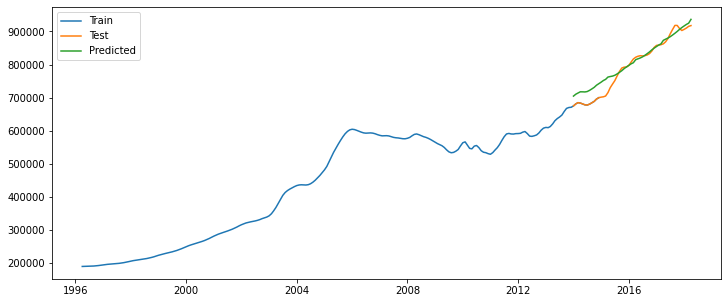

In [33]:
plt.figure(figsize=(12,5))
plt.plot(train_brk[11220], label='Train')
plt.plot(test_brk[11220],label='Test')
plt.plot(future_forecast,label='Predicted')
plt.legend()

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

mse = mean_squared_error(test_brk[11220], future_forecast)
rmse = sqrt(mse)
print(rmse)

24462.197147875693


In [35]:
kings = all_zipcodes[(all_zipcodes['CountyName']=='Kings') & (all_zipcodes['State']== 'NY') &
                    (all_zipcodes['MeanValue']> 300000.0)]
kings

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,Month,MeanValue
427073,62026,11215,New York,NY,New York,Kings,107,1998-09-01,302800.0
441796,62026,11215,New York,NY,New York,Kings,107,1998-10-01,308200.0
456519,62026,11215,New York,NY,New York,Kings,107,1998-11-01,314100.0
471242,62026,11215,New York,NY,New York,Kings,107,1998-12-01,321000.0
485965,62026,11215,New York,NY,New York,Kings,107,1999-01-01,327800.0
...,...,...,...,...,...,...,...,...,...
3887683,62035,11224,New York,NY,New York,Kings,812,2018-04-01,517900.0
3888027,62033,11222,New York,NY,New York,Kings,1156,2018-04-01,1721100.0
3888306,62016,11205,New York,NY,New York,Kings,1435,2018-04-01,2248400.0
3888406,62028,11217,New York,NY,New York,Kings,1535,2018-04-01,3656000.0


In [36]:
kings['Zipcode'].nunique()

28

In [37]:
kings.index

Int64Index([ 427073,  441796,  456519,  471242,  485965,  500631,  500688,
             515354,  515411,  530077,
            ...
            3887238, 3887295, 3887311, 3887347, 3887572, 3887683, 3888027,
            3888306, 3888406, 3890600],
           dtype='int64', length=5193)

### Zipcode: 11217

In [38]:
#make loop
# brooklyn_zips = {}

# for zipcode in kings['Zipcode'].unique(): 
#     all_zips = kings[kings['Zipcode'] == zipcode]
#     all_zips = all_zips.set_index('Month')['MeanValue']
#     all_zips = all_zips.asfreq('MS')
#     brooklyn_zips[zipcode] = all_zips

<AxesSubplot:xlabel='Month'>

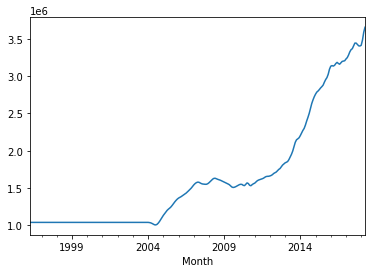

In [39]:
zip_df[11217].plot()

In [40]:
def stationary_test(df):
    rolling_mean = df.rolling(window=12).mean()
    rolling_std = df.rolling(window=12).std()

    plt.plot(df,color='blue',label='orignal')
    plt.plot(rolling_mean, color='red',label='Rolling Mean')
    plt.plot(rolling_std, color='green',label='Rolling STD')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Rolling Standard Deviation')
    #plt.show()
    result = adfuller(df)
    print('ADF statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{} : {}'.format(key,value))
        
    names = ['Test Statistic','p-value','#Lags Used','# of Observations Used']
    res  = dict(zip(names,result[:4]))
    res['Stationary Results'] = res['p-value']<.05
    
    return pd.DataFrame(res,index=['AD Fuller Results'])    

ADF statistic: 0.8851083655203256
p-value: 0.992892876384823
Critical Values:
	1% : -3.4569962781990573
	5% : -2.8732659015936024
	10% : -2.573018897632674


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.885108,0.992893,16,248,False


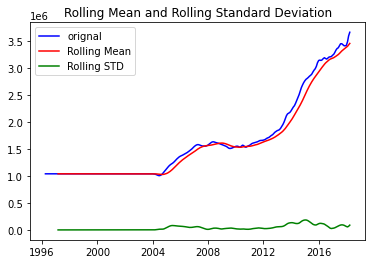

In [41]:
stationary_test(zip_df[11217])

###  Zipcode:  11238

In [42]:
#brooklyn_zips[11238]

ADF statistic: 1.3300142358520741
p-value: 0.9967718123702427
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,1.330014,0.996772,13,251,False


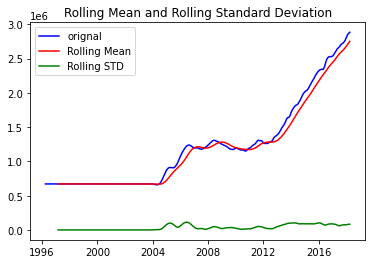

In [43]:
stationary_test(zip_df[11238])

### Zipcode:  11215

ADF statistic: 0.4646259676014641
p-value: 0.9837573347851628
Critical Values:
	1% : -3.4569962781990573
	5% : -2.8732659015936024
	10% : -2.573018897632674


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.464626,0.983757,16,248,False


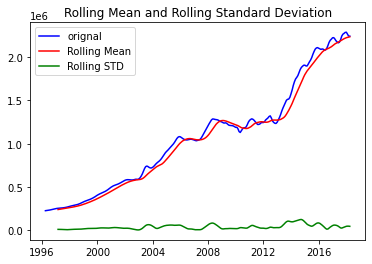

In [44]:
stationary_test(zip_df[11215])

### Removing Trend
#### Log-Transformation (np.log)

ADF statistic: 0.0945230624252297
p-value: 0.9656851626501418
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,0.094523,0.965685,13,251,False


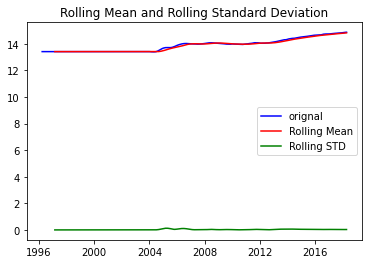

In [45]:
## Log Transform
ts3 = np.log(zip_df[11238])
#ts3.plot()
stationary_test(ts3)

#### Differencing

ADF statistic: -1.9076797092516773
p-value: 0.32845700267119693
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.90768,0.328457,12,251,False


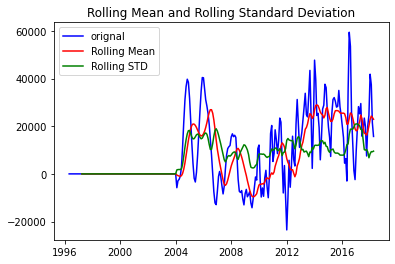

In [46]:
"""
#subtracts the ts 1 step forward from itself. Good way of eliminting trend

#below ts centered around 0
#we achieved stationarity
#eliminating day-to-day patterns
"""
ts0 = zip_df[11238].diff().dropna()
#ts0.plot()

stationary_test(ts0)

#### Subtract Rolling Mean 

ADF statistic: -1.9071669762331833
p-value: 0.3286970868825541
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.907167,0.328697,13,249,False


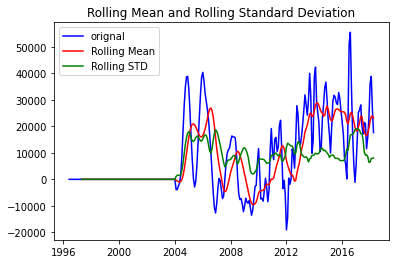

In [47]:
## Subtract Rolling mean
ts2 = (zip_df[11238] - zip_df[11238].rolling(3).mean()).dropna()
#ts2.plot()
stationary_test(ts2)

#### Subtract Exponentially-Weighted Mean 

ADF statistic: -1.2695172364186622
p-value: 0.6430003071656758
Critical Values:
	1% : -3.4566744514553016
	5% : -2.8731248767783426
	10% : -2.5729436702592023


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-1.269517,0.643,13,251,False


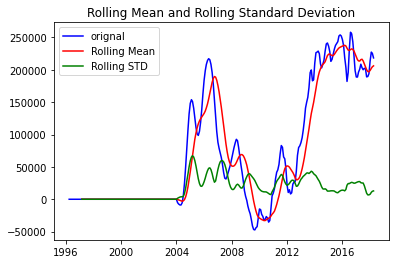

In [48]:
## Subtract Exponentially Weight Mean Rolling mean
ts4 = (zip_df[11238] - zip_df[11238].ewm(halflife=7).mean()).dropna()
#ts4.plot()
stationary_test(ts4)

#### Seasonal Decomposition 

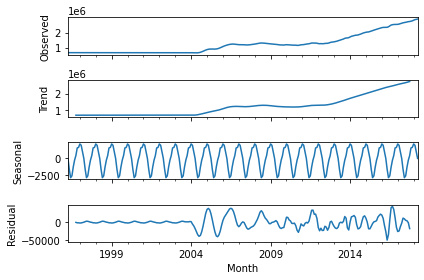

In [49]:
"""
it will identfies patterns, trends in ts and separate them into 3 new ts.
residual-what was left over after removing all the other components.
"""
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(zip_df[11238])#,model='mul')
decomp.plot();

ADF statistic: -3936202969399442.5
p-value: 0.0
Critical Values:
	1% : -3.4568881317725864
	5% : -2.8732185133016057
	10% : -2.5729936189738876


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-3.936203e+15,0.0,15,249,True


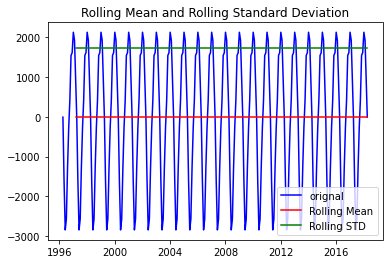

In [50]:
## Get ADFuller Results for seasonal component
stationary_test(decomp.seasonal)

ADF statistic: 1.423078821514143
p-value: 0.9972165043232137
Critical Values:
	1% : -3.4582467982399105
	5% : -2.8738137461081323
	10% : -2.5733111490323846


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,1.423079,0.997217,15,237,False


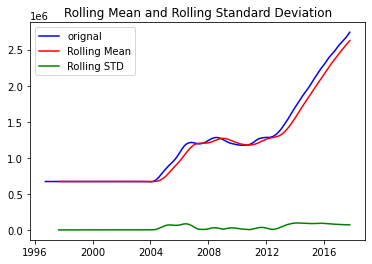

In [51]:
## Get ADFuller Results for trend component
stationary_test(decomp.trend.dropna())

ADF statistic: -5.576233902155626
p-value: 1.4300620546612478e-06
Critical Values:
	1% : -3.458010773719797
	5% : -2.8737103617125186
	10% : -2.5732559963936206


,Test Statistic,p-value,#Lags Used,# of Observations Used,Stationary Results
AD Fuller Results,-5.576234,0.000001,13,239,True


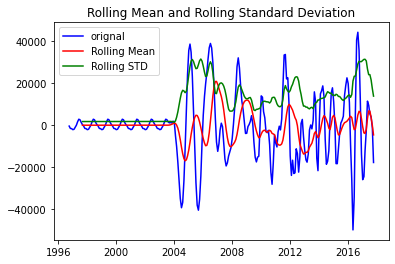

In [52]:
## Get ADFuller Results for resid component
stationary_test(decomp.resid.dropna())

In [53]:
decomp.resid.dropna()

Month
1996-10-01     -417.286706
1996-11-01    -1543.305826
1996-12-01    -1613.940747
1997-01-01    -2127.829636
1997-02-01    -1927.035985
                  ...     
2017-06-01     9493.400523
2017-07-01     5377.924333
2017-08-01     3973.162428
2017-09-01    -1224.853445
2017-10-01   -17713.120040
Freq: MS, Name: 11238, Length: 253, dtype: float64

### GridSearch 

#### Find the values of ARIMA(p,d,q)(P,D,Q)s

In [54]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

#### Identify the set of parameters that will produce the best fitting model to time series dataset.

In [55]:
"""
(AIC) is an estimator of the relative quality of statistical models for a given set of data. 
Given a collection of models for the data, AIC estimates the quality of each model, relative to each of 
    the other models. AIC provides a means for model selection.

Model that fits the data very well while using lots of features will be assigned a larger AIC score than a model
    that uses fewer features to achieve the same goodness-of-fit. 
    We are interested in finding the model that yields the lowest AIC value. 

"""
# Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
def gridsearch_pdq(pdq, pdqs, df):
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([comb, combs, output.aic])
                print('ARIMA {} x {}12 : AIC Calculated ={}'.format(comb, combs, output.aic))
                
            except:
                continue
    
    
    
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'aic'])
    #ans_df.loc[ans_df['aic'].idxmin()]

    
    return ans_df           

In [56]:
gs_pdq = gridsearch_pdq(pdq, pdqs,zip_df[11238])

ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated =8213.126218595695
ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated =7690.372383847679
ARIMA (0, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated =6770.362307042525
ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated =6461.447825371176
ARIMA (0, 0, 0) x (1, 0, 0, 12)12 : AIC Calculated =6590.012697927848
ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated =6560.483562053177
ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated =6283.456480602297
ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated =6257.929031462751
ARIMA (0, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated =7991.823749048385
ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated =8079.520526946769
ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated =6907.405815506904
ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated =2264846.0146940104
ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated =8241.977606343593
ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated =8074.044640172859
ARIMA (0, 0, 1) x (

In [57]:
gs_pdq.sort_values(by='aic')

,pdq,pdqs,aic
63,"(1, 1, 1)","(1, 1, 1, 12)",5.013629e+03
59,"(1, 1, 1)","(0, 1, 1, 12)",5.018709e+03
62,"(1, 1, 1)","(1, 1, 0, 12)",5.048530e+03
54,"(1, 1, 0)","(1, 1, 0, 12)",5.062416e+03
55,"(1, 1, 0)","(1, 1, 1, 12)",5.065884e+03
...,...,...,...
13,"(0, 0, 1)","(1, 0, 1, 12)",8.074045e+03
9,"(0, 0, 1)","(0, 0, 1, 12)",8.079521e+03
0,"(0, 0, 0)","(0, 0, 0, 12)",8.213126e+03
12,"(0, 0, 1)","(1, 0, 0, 12)",8.241978e+03


In [58]:
# Find the parameters with minimal AIC value
ans_df = pd.DataFrame(gs_pdq, columns=['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (1, 1, 1)
pdqs    (1, 1, 1, 12)
aic           5013.63
Name: 63, dtype: object

### Creating a SARIMA TS Model

In [59]:
"""
Using grid search, we have identified the set of parameters that produces the best fitting model 
    to our time series data. 

coef column above shows the importance of each feature and how each one impacts the time series patterns. 
The P>|z| provides the significance of each feature weight.

each weight has a p-value lower or close to 0.05, so it is reasonable to retain all of them in our model.

model diagnostics-The purpose is to ensure that residuals remain uncorrelated, normally distributed having zero mean.
where N(0,1)) is the standard notation for a normal distribution with mean 0 and standard deviation of 1). 
This is a good indication that the residuals are normally distributed.



# Plug the optimal parameter values into a new SARIMAX model
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(brooklyn_zips[11238], 
                                        order=(1, 1, 1), 
                                        seasonal_order=(1, 1, 1, 12), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()

print(output.summary().tables[1])
"""
def fit_ARIMA(df, order=None, seasonal_order=None):
    ARIMA_MODEL = sm.tsa.statespace.SARIMAX(df, 
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

    # Fit the model and print results
    output = ARIMA_MODEL.fit()

    #display / no tables 1
    print(output.summary().tables[1])
    
    print('\n')
    print('MODEL DIAGNOSTICS')
    
    output.plot_diagnostics(figsize=(15, 18));
    
    return output

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6873      0.045     15.420      0.000       0.600       0.775
ma.L1          0.3540      0.031     11.303      0.000       0.293       0.415
ar.S.L12      -0.3288      0.071     -4.603      0.000      -0.469      -0.189
ma.S.L12      -0.0368      0.058     -0.633      0.527      -0.151       0.077
sigma2      8.221e+07   2.84e-10    2.9e+17      0.000    8.22e+07    8.22e+07


MODEL DIAGNOSTICS


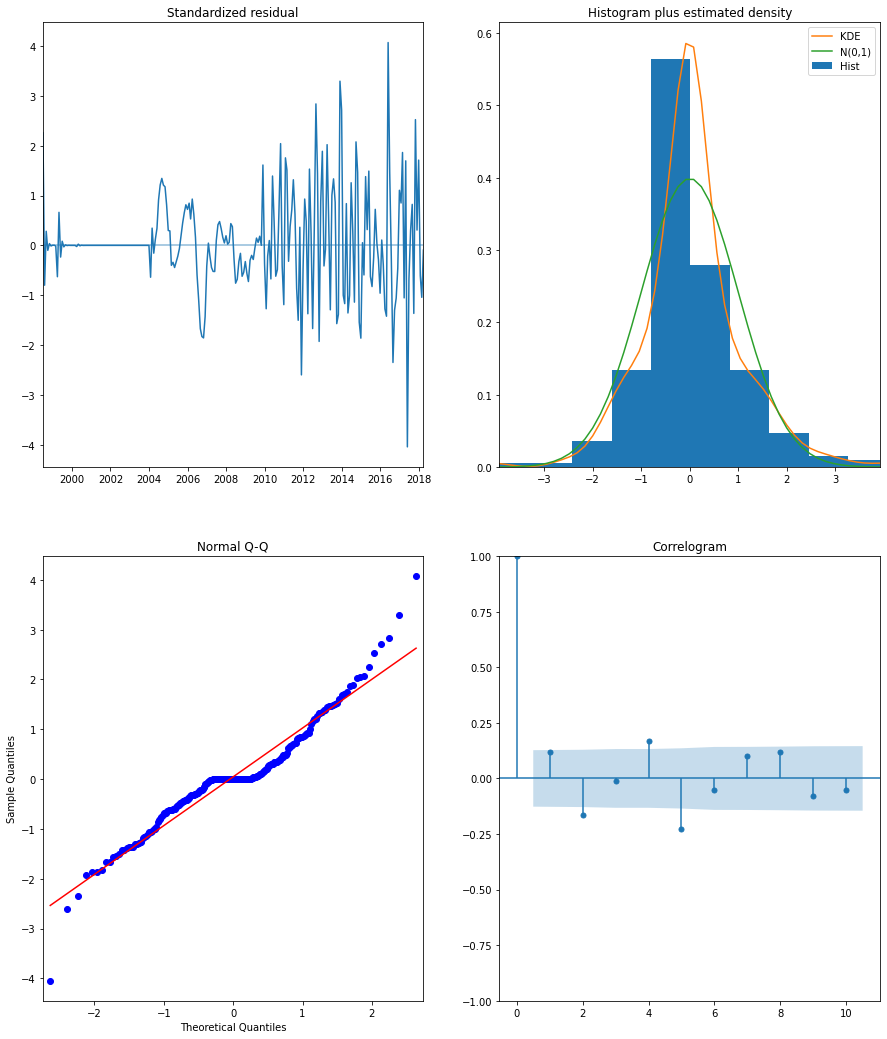

In [60]:
output_summ = fit_ARIMA(zip_df[11238], order=(1,1,1), seasonal_order=(1,1,1,12))

### Validating the Model

In [61]:
zip_df[11238].head()

Month
1996-04-01    671200.0
1996-05-01    671200.0
1996-06-01    671200.0
1996-07-01    671200.0
1996-08-01    671200.0
Freq: MS, Name: 11238, dtype: float64

In [62]:
"""
start by comparing predicted values to real values of the time series, which will help us understand the accuracy of 
    our forecasts

plot the real and forecasted values of the time series to assess how well we did

"""
# Get predictions starting from 01-01-1998 and calculate confidence intervals
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=True)
pred_conf = pred.conf_int()

In [63]:
pred_conf

,lower 11238,upper 11238
Month,,
2016-01-01,2.311733e+06,2.347275e+06
2016-02-01,2.312395e+06,2.393185e+06
2016-03-01,2.302481e+06,2.429480e+06
2016-04-01,2.305329e+06,2.476974e+06
2016-05-01,2.311142e+06,2.524950e+06
2016-06-01,2.314008e+06,2.567266e+06
2016-07-01,2.320503e+06,2.610569e+06
2016-08-01,2.331039e+06,2.655468e+06
2016-09-01,2.343588e+06,2.700179e+06


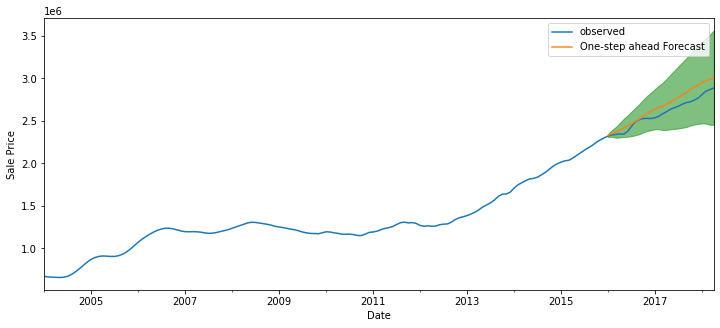

In [64]:
# Plot real vs predicted values along with confidence interval

plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()
#confidence interval

In [65]:
"""
check for the accuracy of our forecasts using MSE (Mean Squared Error). 
This will provide us with the average error of our forecasts

An MSE this close to 0 indicates that the estimator is predicting observations of the parameter with perfect 
    accuracy, which would be an ideal
"""
# Get the real and predicted values
forecasted_11238 = pred.predicted_mean
truth_1128 = zip_df[11238]['2004':]

# Compute the mean square error
mse = ((forecasted_11238 - truth_1128) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
#np.sqrt(np.mean((predictions-targets)**2))
rmse = np.sqrt(np.mean((forecasted_11238 - truth_1128) ** 2))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 2)))

The Mean Squared Error of our forecasts is 8750875016.05
The Root Mean Squared Error of our forecasts is 93546.11


In [66]:
"""
pred = output.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=False)
pred_conf = pred.conf_int()
"""
pred = output_summ.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
pred_conf = pred.conf_int()

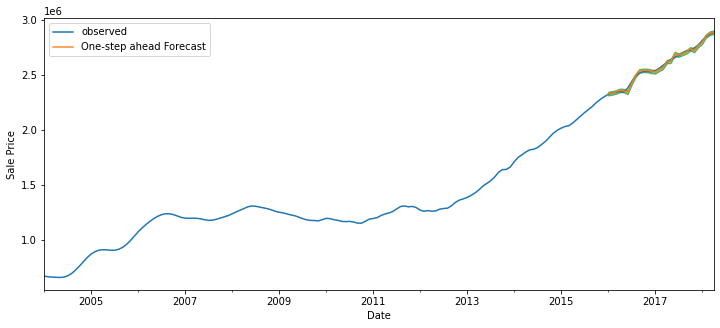

In [67]:
# Plot the dynamic forecast with confidence intervals.
plt.figure(figsize=(12,5))
# Plot observed values
ax = zip_df[11238]['2004':].plot(label='observed')

# Plot predicted values
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=0.9)

# Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=0.5)

# Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Sale Price')
plt.legend()


### AUTOARIMA Model

In [68]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [69]:
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm

from sklearn.model_selection import train_test_split


In [70]:
from pmdarima import auto_arima

In [71]:
"""
stepwise-stepping through different combinations
trace=let's us see different models that auto arima tried out
reports back aic and bic
lot's similar aic values, it figures out that it's no longer worth to increase order of more complex models
    all the way to max_p=6 value
    instead it say these ar estaying the same. No longer worth it to increase aic b/c it' something we're trying to 
    minimize.
    
"""
#stepwise_fit = auto_arima(,start_p=0, start_q=0,max_p=6,max_q=3, trace=True)

"\nstepwise-stepping through different combinations\ntrace=let's us see different models that auto arima tried out\nreports back aic and bic\nlot's similar aic values, it figures out that it's no longer worth to increase order of more complex models\n    all the way to max_p=6 value\n    instead it say these ar estaying the same. No longer worth it to increase aic b/c it' something we're trying to \n    minimize.\n    \n"

In [72]:
"""
gives summary of bet performing model that autoarima thinks we should use.
"""
#stepwise_fit.summary()

'\ngives summary of bet performing model that autoarima thinks we should use.\n'

In [73]:
"""
create an arima model using statsmodel of order 0,2,0
train tst split
forecasting
don't need to read auto_correlation and partial auto_correlation plots

defaults are 2,2
0. or 1. p,q
seasonal by default=True
see rtace results of different arima models
m= number of periods per season
    there is normal differencing and seasonal differencing
    4 for quarterly data 
    12 for monthly data
    1 for annual for non-seasonal data
    
 abd sarimax model   
"""
# def autoarima_model(df):
#     stepwise_fit_1 = auto_arima(df,start_p=0, start_q=0,max_p=6,max_q=6, seasonal=True, 
#                             trace=True,m=12)
    
#     print('\n')
#     print(stepwise_fit_1.summary())
#     return stepwise_fit_1

"\ncreate an arima model using statsmodel of order 0,2,0\ntrain tst split\nforecasting\ndon't need to read auto_correlation and partial auto_correlation plots\n\ndefaults are 2,2\n0. or 1. p,q\nseasonal by default=True\nsee rtace results of different arima models\nm= number of periods per season\n    there is normal differencing and seasonal differencing\n    4 for quarterly data \n    12 for monthly data\n    1 for annual for non-seasonal data\n    \n abd sarimax model   \n"

In [74]:
#autoarima_model(brooklyn_zips[11238])

In [75]:
"""
this is whatwe should apss into statsmodels when performing forecasting
returns best performing model

"""
#stepwise_fit_1.summary()

'\nthis is whatwe should apss into statsmodels when performing forecasting\nreturns best performing model\n\n'

In [76]:
#train test split
#brook_zip = brooklyn_zips[11238]

In [77]:
"""
birth_train = f_births[0:330]
birth_test = f_births[330:365]

shampoo_train = shampoo[0:25]
shampoo_test = shampoo[25:36]
"""

# train = brooklyn_zips[11238][0:138]
# test = brooklyn_zips[11238][138:172]

'\nbirth_train = f_births[0:330]\nbirth_test = f_births[330:365]\n\nshampoo_train = shampoo[0:25]\nshampoo_test = shampoo[25:36]\n'

In [78]:
# print(train.shape)
# print(test.shape)

In [79]:
# plt.plot(train)
# plt.plot(test)

### Build AutoArima Model

In [80]:
"""
AIC and BIC depend on log liklihood

"""
# arima_model = auto_arima(brooklyn_zips[11238],start_p=1, start_q=1,
           
#                             start_P=0, start_Q=0, D=1,max_P=5,max_D=5,max_Q=5, m=12,
#                             seasonal=True, error_action='warn',trace=True, stepwise=True,
#                            random_state=20, n_fits=50)
# arima_model = auto_arima(brooklyn_zips[11238],start_p=1, start_q=1, 
#                              max_p=3,max_q=3,m=12,d=1, D=1, trace=True,  error_action='ignore',
#                              suppress_warnings=True, stepwise=True)

'\nAIC and BIC depend on log liklihood\n\n'

In [81]:
def train_test(X, perct=None): 
    train_size = int(len(X) * perct)
    train, test = X[0:train_size], X[train_size: len(X)]
    print('Observations:{}'.format(len(X)))
    print('Train Set: {}'.format(len(train)))   
    print('Test Set: {}'.format(len(test))) 

    return train, test

In [82]:
#train, test = train_test(brooklyn_zips[11238])

In [83]:
"""
create an arima model using statsmodel of order 0,2,0
train tst split
forecasting
don't need to read auto_correlation and partial auto_correlation plots

defaults are 2,2
0. or 1. p,q
seasonal by default=True
see rtace results of different arima models
m= number of periods per season
    there is normal differencing and seasonal differencing
    4 for quarterly data 
    12 for monthly data
    1 for annual for non-seasonal data
    
 abd sarimax model   

"""
def arima_model(df):
    autoarima_model = auto_arima(df, start_p = 1, start_q = 1, 
                              test='adf',             # use adftest to find optimal 'd'
                              max_p = 3, max_q = 3,   # maximum p and q
                              m = 12,                  #frequency of series 
                              d = 1,               # let model determine 'd'
                              seasonal = True, 
                              start_P=1, D=1, trace = True, 
                              error_action ='ignore',   # we don't want to know if an order does not work 
                              suppress_warnings = True,  # we don't want convergence warnings 
                              stepwise = True)           # set to stepwise  
    
    print('\n')
    print(autoarima_model.summary())
    
    #autoarima_model.plot_diagnostics(figsize=(12,10))
    
    return autoarima_model

    #autoarima_model.summary()

In [84]:
#sf = arima_model()

In [85]:
#sf.summary()

In [86]:
"""
AIC- which estimates the relative amount of information lost by a given model
a lower AIC value is preferred

"""
#print(sf.aic())

'\nAIC- which estimates the relative amount of information lost by a given model\na lower AIC value is preferred\n\n'

In [87]:
# sf.plot_diagnostics()
# plt.figure(figsize=(12,10))

### Train Test Split

In [88]:
#train, test = train_test(brooklyn_zips[11238], perct=0.80)

In [89]:
#len(train)

### Forecasting on Test Data

In [90]:
# #length of test data
# future_forecast = sf.predict(n_periods=35)
# print(future_forecast)

In [91]:
# future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
# pd.concat([brooklyn_zips[11238],future_forecast],axis=1).plot()

In [92]:
# plt.figure(figsize=(12,5))
# plt.plot(train, label='Train')
# plt.plot(test,label='Test')
# plt.plot(future_forecast,label='Predicted')
# plt.legend()

In [93]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt

# mse = mean_squared_error(test, future_forecast)
# rmse = sqrt(mse)
# print(rmse)

#### Return on Investment

In [94]:
investment = 40000
rent = 700
loss = 1000  #cost of 1000 per year

def roi(investment, rent, loss):
    """
    return on investment is calcualted by net_profit / investment * 100
    12 = # of months in year 
    investment part doesn't need to be touched investment amount is just capital cost of building
    """
    netprofit = rent * 12 - loss
    ROI = (netprofit / investment) * 100
    print(ROI)
    
#roi(investment, rent, loss) 
#calculated return on investment for these parameters
roi(investment, rent, loss)   

18.5
